# Image Classification

### import libraries we needed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms, models, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader , Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### preprocessing

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_set = CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = DataLoader(train_set,batch_size=32,shuffle=True)

test_set = CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = DataLoader(test_set,batch_size=32,shuffle=False)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

100%|██████████| 170M/170M [00:18<00:00, 9.14MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Showing some sampels

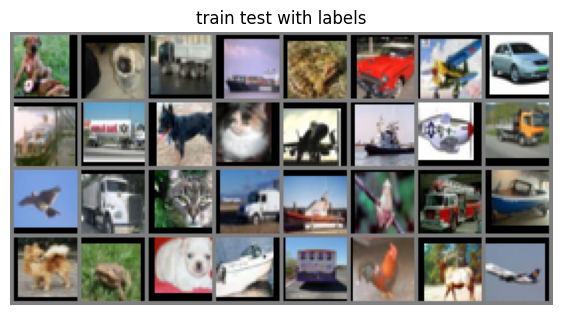

In [4]:
def imshow(img):
  plt.figure(figsize=((7,7)))
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.axis('off')
  plt.title('train test with labels')
  plt.show()

    # Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(32)))

# CNN model

In [5]:
#  CNN Model Definition
class CIFAR10_CNN(nn.Module):
  def __init__(self):
      super(CIFAR10_CNN, self).__init__()
      self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
      self.bn1 = nn.BatchNorm2d(64)
      self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
      self.bn2 = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
      self.bn3 = nn.BatchNorm2d(256)
      self.pool = nn.MaxPool2d(2, 2)
      self.dropout = nn.Dropout(0.25)
      self.fc1 = nn.Linear(256 * 4 * 4, 512)
      self.fc2 = nn.Linear(512, 256)
      self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      x = self.pool(F.relu(self.bn3(self.conv3(x))))
      x = x.view(-1, 256 * 4 * 4)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

model = CIFAR10_CNN()

dog dog truck ship frog car plane car ship truck dog cat plane ship plane truck bird truck cat truck ship frog truck ship dog frog dog ship truck bird deer plane


In [6]:
model

CIFAR10_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

### Loss Function and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizar = optim.Adam(model.parameters(),lr=0.0001)

### Training Loop

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.train()
for epoch in range(11):
    for data in trainloader:
        inputs , labels = data
        inputs , labels = inputs.to(device) , labels.to(device)
        optimizar.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizar.step()
    print(f'Epoch {epoch+1} Loss: {loss.item()}')


Epoch 1 Loss: 0.1464303433895111
Epoch 2 Loss: 0.25185081362724304
Epoch 3 Loss: 0.003472789190709591
Epoch 4 Loss: 0.015005038119852543
Epoch 5 Loss: 0.15602560341358185
Epoch 6 Loss: 0.13132929801940918
Epoch 7 Loss: 0.037631843239068985
Epoch 8 Loss: 0.16421575844287872
Epoch 9 Loss: 0.14050860702991486
Epoch 10 Loss: 0.07589498162269592
Epoch 11 Loss: 0.009198020212352276


### Testing the Model

In [26]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for data in testloader:
    images , labels = data
    images , labels = images.to(device) , labels.to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

Accuracy of the model on the 10000 test images: 88.04 %


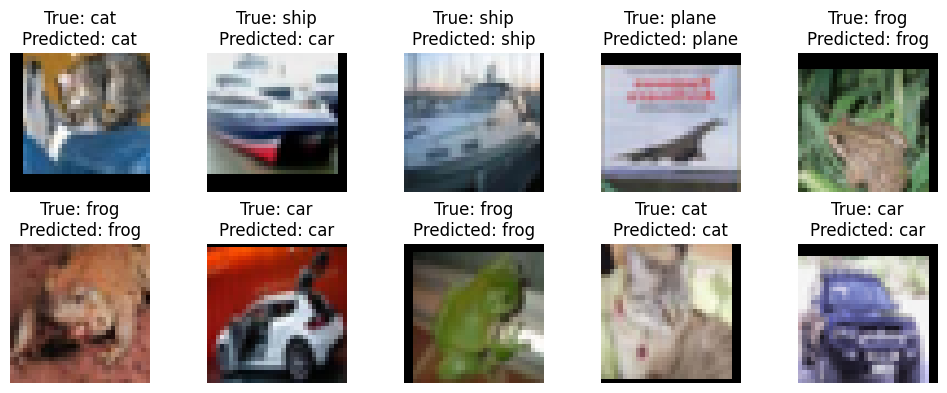

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images[:10])
_, predicted = torch.max(outputs.data, 1)

images = images[:10].cpu()
labels = labels[:10].cpu()
predicted = predicted.cpu()

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)) / 2 + 0.5)
    ax.set_title(f"True: {classes[labels[i]]}\nPredicted: {classes[predicted[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()